# **4.03 - Learning Vector Quantization (LVQ)**


In [ ]:
# Bibliotecas Externas
import os
import warnings
import pandas as pd

# Ignorando Warnings
warnings.filterwarnings("ignore")

# Bibliotecas Locais
os.chdir("../..")
from lib import plots, runner, util

# Definido Variáveis globais
N_SPLITS = 5
RANDOM_STATE = 51

# Conjunto de treino
X_train = pd.read_csv('./data/processed/X_train.csv')
Y_train = pd.read_csv('./data/processed/Y_train.csv')

Y_train['class'] = Y_train['class'].apply(lambda val: 1 if val == 'UP' else 0)

# Conjunto de validação
X_val = pd.read_csv('./data/processed/X_val.csv')
Y_val = pd.read_csv('./data/processed/Y_val.csv')


Y_val['class'] = Y_val['class'].apply(lambda val: 1 if val == 'UP' else 0)

# Conjunto de teste
X_test = pd.read_csv('./data/processed/X_test.csv')
Y_test = pd.read_csv('./data/processed/Y_test.csv')

Y_test['class'] = Y_test['class'].apply(lambda val: 1 if val == 'UP' else 0)

## 1. Deifinição do Modelo

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from random import randrange
from math import sqrt


# calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += (row1[i] - row2[i])**2
    return sqrt(distance)

# Locate the best matching unit
def get_best_matching_unit(codebooks, test_row):
    distances = list()
    for codebook in codebooks:
        dist = euclidean_distance(codebook, test_row)
        distances.append((codebook, dist))
    distances.sort(key=lambda tup: tup[1])
    return distances[0][0]

# Make a prediction with codebook vectors
def predict(codebooks, test_row):
    bmu = get_best_matching_unit(codebooks, test_row)
    return bmu[-1]

# Create a random codebook vector
def random_codebook(train):
    n_records = len(train)
    n_features = len(train[0])
    codebook = [train[randrange(n_records)][i] for i in range(n_features)]
    return codebook

# Train a set of codebook vectors
def train_codebooks(train, n_codebooks, lrate, epochs):
    codebooks = [random_codebook(train) for i in range(n_codebooks)]
    for epoch in range(epochs):
        rate = lrate * (1.0 - (epoch / float(epochs)))
        for row in train:
            bmu = get_best_matching_unit(codebooks, row)
            for i in range(len(row)-1):
                error = row[i] - bmu[i]
                if bmu[-1] == row[-1]:
                    bmu[i] += rate * error
                else:
                    bmu[i] -= rate * error
    print("Fim do treinameno")
    return codebooks

# LVQ Algorithm as a custom classifier
class LVQClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_codebooks=10, lrate=0.1, epochs=100):
        self.n_codebooks = n_codebooks
        self.lrate = lrate
        self.epochs = epochs
    
    def fit(self, X, y):
        # Combine features and labels
        train = np.column_stack((X, y))
        self.codebooks_ = train_codebooks(train, self.n_codebooks, self.lrate, self.epochs)
        return self

    def predict(self, X):
        predictions = [predict(self.codebooks_, row) for row in X]
        return np.array(predictions)
    
    def predict_proba(self, X):
        # Return probabilities for each class. This is an approximation based on distance from codebooks.
        probabilities = []
        for row in X:
            bmu = get_best_matching_unit(self.codebooks_, row)
            class_label = bmu[-1]
            # For simplicity, we will return a binary classification probability for each class
            prob = [0.0, 0.0]  # Assuming binary classification
            prob[class_label] = 1.0  # Fully confident in the class of the BMU
            probabilities.append(prob)
        return np.array(probabilities)

    def decision_function(self, X):
        # This function will return the distances to the codebooks, which can be used for decision making
        distances = []
        for row in X:
            bmu = get_best_matching_unit(self.codebooks_, row)
            dist = euclidean_distance(bmu, row)
            distances.append(dist)
        return np.array(distances)

O LVQ é um algoritmo de aprendizado supervisionado que cria um conjunto de vetores de código (protótipos) que representam as diferentes classes nos dados. Assim, durante o treinamento, esses vetores de código são ajustados para se aproximarem dos pontos de dados da mesma classe e se afastarem dos pontos de dados de classes diferentes, gerando separações no espaço vetorial. Desse modo, na classificação, o novo ponto de dados é atribuído à classe do vetor de código mais próximo.


## 2. Configuração de Hiperparâmetros


In [6]:
param_distributions_lvq = {
    'n_codebooks': [5, 10, 30, 50, 100],
    'lrate': [0.01, 0.05, 0.1, 0.5],
    'epochs': [2, 20, 50, 100]
}

Para o LVQ avaliamos os seguintes hiperparâmetros: n_codebooks, learn_rate e n_epochs. A primeira permite a variação do número de protótipos entre 5 e 30 permite explorar diferentes níveis de complexidade na representação das classes, adaptando o modelo à estrutura dos dados. Um número insuficiente de protótipos pode levar à simplificação excessiva e underfitting, enquanto um número excessivo pode resultar em overfitting, daí a necessidade de um intervalo que abranja diversas possibilidades.

Já a taxa de aprendizado (learn_rate), variando de 0.01 a 0.5, controla a magnitude das atualizações dos protótipos durante o treinamento. Taxas de aprendizado muito baixas podem tornar o treinamento lento e dificultar a convergência, enquanto taxas muito altas podem levar a oscilações e instabilidade.

Por fim, o número de épocas (n_epochs), variando de 10 a 100, define o número de iterações completas sobre o conjunto de treinamento. Um número insuficiente de épocas pode impedir que o modelo convirja, enquanto um número excessivo pode levar a overfitting. Assim, o intervalo escolhido permite explorar diferentes durações de treinamento, adaptando-se à complexidade dos dados e à velocidade de convergência do modelo.

## 3. Avaliação do Modelo

O Modelo **LVQ** foi configurado com os melhores parâmetros possíveis para a nossa bancada de testes. Por ter sido um algoritmo que utilizou a implementação feita em sala, ele não possuía um tempo de treinamento adequado, fazendo com que quanto mais aumentássemos os notebooks e as épocas, maior seria o tempo de treinamento. Ele foi o modelo que mais demorou na bancada de testes, cerca de 12 horas, com isso não conseguimos trabalhar em uma maior variedade de hiperparâmetros. No geral, o modelo não apresentou resultados muito positivos, sendo o pior modelo testado nessa bateria de testes

**Curva ROC e Matriz de Confusão:**

A análise da curva ROC e da matriz de confusão revela um pouco abaixo do modelo. A curva ROC mostra que o modelo com o melhor valor de AUC (área sob a curva) supera significativamente a média dos modelos e o modelo aleatório, evidenciando uma boa capacidade de discriminação entre as classes para essa combinação de hiperparâmetros, demonstrando como ela foi efetiva. A matriz de confusão, por outro lado, indica que o modelo é eficaz em prever a classe DOWN (negativa), com um bom número de acertos (1844), mas ainda apresenta uma quantidade considerável de falsos positivos (633). Para a classe UP (positiva), o modelo acerta 1127 previsões, mas comete 580 falsos negativos, sugerindo que há espaço para melhorias, especialmente na identificação correta da classe UP.

**Métricas de Desempenho entre os modelos:**

Nos gráficos apresentados, o primeiro demonstra que o melhor modelo supera significativamente a média de todos os outros, com todos os valores das métricas do melhor modelo sendo superiores aos da média. Isso sugere que como a busca de hiperparâmetros foi eficaz, produzindo um modelo mais assertivo, ainda que com um desempenho não tão alto, evidenciando a dificuldade do algoritmo para essa base de dados.

O segundo gráfico compara o desempenho das métricas ao longo de diferentes modelos. Nele, observa-se uma variação significativa, especialmente em **f1_score** e **recall**, indicando que, em certos modelos, o equilíbrio entre acurácia e capacidade de identificar positivos pode ser desafiador. Ainda assim, esses resultados devem ser considerados anôma-los, provavelmente devido a algum problema na implementação no preditor do algoritmo, que levou a valores como 0.

**Desempenho Cross Validation:**

O gráfico mostra o desempenho do modelo de Learning Vector Quantization (LVQ) durante a validação cruzada, comparando o desempenho entre os conjuntos de treino e teste ao longo de cinco divisões (splits). A linha vermelha, que representa o desempenho no conjunto de treino, exibe flutuações ao longo dos splits. Isso sugere que o modelo tem um bom desempenho nos dados de treino, mas a diferença em relação à linha azul (desempenho no teste) indica que o modelo pode estar começando a overfitar, ou seja, ele aprende excessivamente os dados de treino e perde capacidade de generalização para os dados não vistos. 

**Métricas do Melhor modelo:**

| Métrica | Melhor Valor Geral | Média | Desvio Padrão | Valor no Modelo Selecionado |
| --- | --- | --- | --- | --- |
| **Accuracy Train** | 0.7116 | 0.6495 | 0.0476 | **0.7116** |
| **Accuracy Val** | 0.7083 | 0.6448 | 0.0480 | **0.7083** |
| **Accuracy Test** | 0.7101 | 0.6506 | 0.0426 | **0.7101** |
| **F1 Score** | 0.6501 | 0.4376 | 0.2315 | **0.6501** |
| **AUC** | 0.7023 | 0.6129 | 0.0696 | **0.7023** |
| **Recall** | 0.6602 | 0.4080 | 0.2294 | 0.6602 |

**Melhor Combinação de Hiperparâmetros:**

```python
{'epochs': 100, 
 'lrate': 0.05, 
 'n_codebooks': 100}
```


In [ ]:
lvq_model = LVQClassifier()

result, model, cv, loss, all_cv = runner.search_paramsv2(lvq_model, param_distributions_lvq, 'lvq',
                              [X_train, Y_train, X_val, Y_val, X_test, Y_test], n_iter=100)

df=pd.DataFrame((result.values()))
df

Realizando a Busca de Parâmetros por 20 iterações:   0%|          | 0/20 [00:00<?, ?it/s]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:   5%|▌         | 1/20 [45:19<14:21:16, 2719.82s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  10%|█         | 2/20 [1:22:22<12:08:11, 2427.33s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  15%|█▌        | 3/20 [1:44:34<9:06:01, 1927.13s/it] 

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  20%|██        | 4/20 [2:04:37<7:17:43, 1641.49s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  25%|██▌       | 5/20 [2:34:40<7:04:55, 1699.73s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  30%|███       | 6/20 [2:59:28<6:19:47, 1627.66s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  35%|███▌      | 7/20 [3:27:44<5:57:29, 1649.94s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  40%|████      | 8/20 [3:43:37<4:45:36, 1428.06s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  45%|████▌     | 9/20 [4:02:57<4:06:28, 1344.38s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  50%|█████     | 10/20 [4:40:34<4:31:01, 1626.13s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  55%|█████▌    | 11/20 [5:09:36<4:09:13, 1661.47s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  60%|██████    | 12/20 [5:54:59<4:24:35, 1984.43s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  65%|██████▌   | 13/20 [6:24:06<3:43:07, 1912.55s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  70%|███████   | 14/20 [6:56:08<3:11:32, 1915.49s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno


/tmp/ipykernel_15807/3722597454.py:5: RuntimeWarning: overflow encountered in scalar add
/tmp/ipykernel_15807/3722597454.py:5: RuntimeWarning: overflow encountered in scalar power
/tmp/ipykernel_15807/3722597454.py:41: RuntimeWarning: overflow encountered in scalar subtract
/tmp/ipykernel_15807/3722597454.py:39: RuntimeWarning: invalid value encountered in scalar add


Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno


/tmp/ipykernel_15807/3722597454.py:5: RuntimeWarning: overflow encountered in scalar add
/tmp/ipykernel_15807/3722597454.py:5: RuntimeWarning: overflow encountered in scalar power
/tmp/ipykernel_15807/3722597454.py:41: RuntimeWarning: overflow encountered in scalar subtract
/tmp/ipykernel_15807/3722597454.py:39: RuntimeWarning: invalid value encountered in scalar add


Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

/tmp/ipykernel_15807/3722597454.py:5: RuntimeWarning: overflow encountered in scalar add
/tmp/ipykernel_15807/3722597454.py:5: RuntimeWarning: overflow encountered in scalar power
/tmp/ipykernel_15807/3722597454.py:41: RuntimeWarning: overflow encountered in scalar subtract
/tmp/ipykernel_15807/3722597454.py:39: RuntimeWarning: invalid value encountered in scalar add


Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno


Realizando a Busca de Parâmetros por 20 iterações:  75%|███████▌  | 15/20 [8:02:14<3:31:07, 2533.46s/it]

Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno
Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  80%|████████  | 16/20 [8:45:48<2:50:31, 2557.80s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  85%|████████▌ | 17/20 [8:59:24<1:41:42, 2034.00s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  90%|█████████ | 18/20 [9:28:30<1:04:54, 1947.30s/it]

Fim do treinameno
Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  95%|█████████▌| 19/20 [9:51:31<29:37, 1777.22s/it]  

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações: 100%|██████████| 20/20 [10:16:54<00:00, 1850.74s/it]


,params,score,model_time,accuracy_train,accuracy_val,accuracy_test,f1_score,recall,auc,fpr,tpr,model_path
0,"{'n_codebooks': 30, 'lrate': 0.1, 'epochs': 100}",NaN,140.326295,0.691973,0.692087,0.690010,0.617742,0.613943,0.678186,"[0.0, 0.25756964069438837, 1.0]","[0.0, 0.6139425893380199, 1.0]",./models/lvq/0.pkl
1,"{'n_codebooks': 50, 'lrate': 0.05, 'epochs': 2}",NaN,4.824263,0.684391,0.682525,0.680927,0.575517,0.530170,0.657495,"[0.0, 0.21517965280581347, 1.0]","[0.0, 0.5301698886936145, 1.0]",./models/lvq/1.pkl
2,"{'n_codebooks': 5, 'lrate': 0.01, 'epochs': 20}",NaN,5.776161,0.621280,0.610328,0.626195,0.441029,0.361453,0.585046,"[0.0, 0.19136051675413807, 1.0]","[0.0, 0.36145284124194493, 1.0]",./models/lvq/2.pkl
3,"{'n_codebooks': 5, 'lrate': 0.05, 'epochs': 50}",NaN,14.294660,0.595871,0.591681,0.597275,0.465927,0.430580,0.571366,"[0.0, 0.28784820347194184, 1.0]","[0.0, 0.4305799648506151, 1.0]",./models/lvq/3.pkl
4,"{'n_codebooks': 10, 'lrate': 0.05, 'epochs': 2}",NaN,1.042939,0.637928,0.635429,0.637906,0.421093,0.322789,0.588928,"[0.0, 0.1449333871618894, 1.0]","[0.0, 0.322788517867604, 1.0]",./models/lvq/4.pkl
5,"{'n_codebooks': 100, 'lrate': 0.01, 'epochs': 2}",NaN,9.301427,0.677732,0.672723,0.670411,0.593575,0.589924,0.657901,"[0.0, 0.27412192167945093, 1.0]","[0.0, 0.5899238429994141, 1.0]",./models/lvq/5.pkl
6,"{'n_codebooks': 50, 'lrate': 0.1, 'epochs': 100}",NaN,232.244040,0.697095,0.691609,0.696224,0.631274,0.637376,0.687077,"[0.0, 0.26322163907953167, 1.0]","[0.0, 0.6373755125951962, 1.0]",./models/lvq/6.pkl
7,"{'n_codebooks': 5, 'lrate': 0.01, 'epochs': 20}",NaN,5.703035,0.582142,0.578293,0.592017,0.000000,0.000000,0.500000,"[0.0, 1.0]","[0.0, 1.0]",./models/lvq/7.pkl
8,"{'n_codebooks': 30, 'lrate': 0.05, 'epochs': 20}",NaN,28.308486,0.663337,0.654793,0.663480,0.543154,0.490334,0.636568,"[0.0, 0.21719822365765037, 1.0]","[0.0, 0.4903339191564148, 1.0]",./models/lvq/8.pkl
9,"{'n_codebooks': 50, 'lrate': 0.1, 'epochs': 2}",NaN,4.749943,0.694944,0.685632,0.686424,0.586381,0.544815,0.664414,"[0.0, 0.21598708114654824, 1.0]","[0.0, 0.5448154657293497, 1.0]",./models/lvq/9.pkl


UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('float64'), dtype('<U1')) -> None

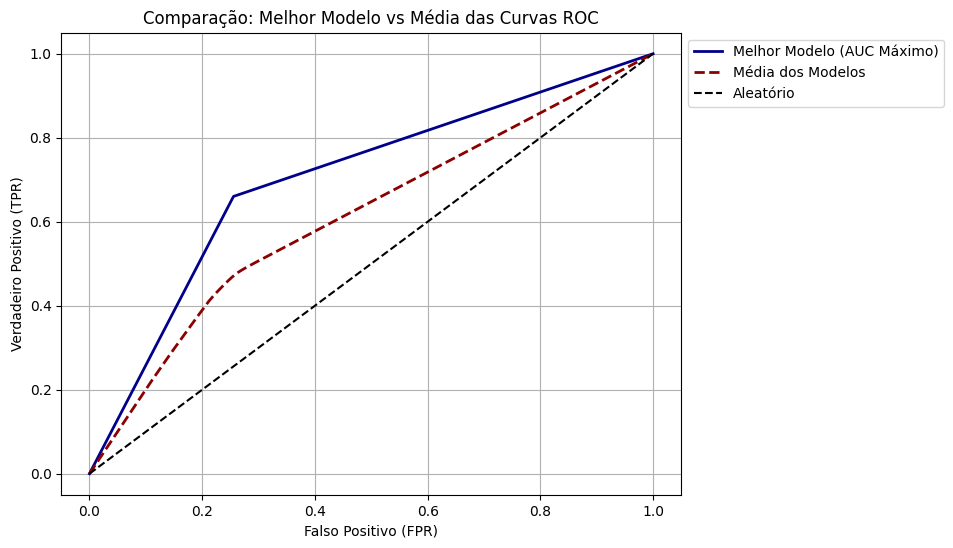

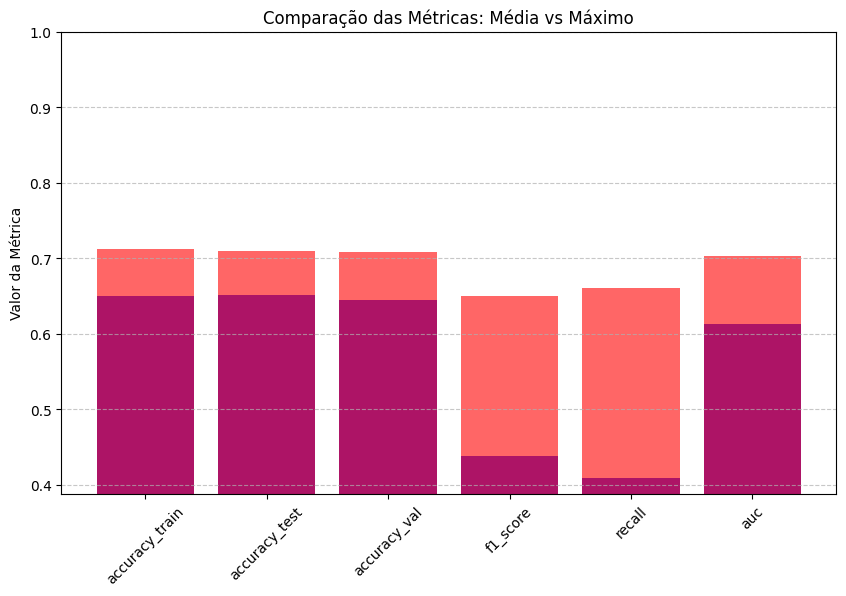

In [23]:
from IPython.display import display, Markdown

plots.show_best_roc(df)
plots.show_bar_metrics2(df)
plots.show_confusion_matrix(model, X_test, Y_test)
plots.show_metrics_comparison_line_plot(df)
plots.plot_cv_performance(cv, "Desempenho do Melhor Modelo na Cross Validation")
plots.plot_cv_performance(all_cv, "Desempenho Médio dos Modelos Selecionados na Cross Validation")
display(Markdown(util.generate_markdown_report(model, result.values())))

In [17]:
df = pd.read_csv('/home/guilhermemaciel/Área de Trabalho/SI5-ELEC2/data/results/lvq.csv')
df

,params,score,model_time,accuracy_train,accuracy_val,accuracy_test,f1_score,recall,auc,fpr,tpr,model_path
0,"{'n_codebooks': 30, 'lrate': 0.1, 'epochs': 100}",NaN,140.326295,0.691973,0.692087,0.690010,0.617742,0.613943,0.678186,"[np.float64(0.0), np.float64(0.257569640694388...","[np.float64(0.0), np.float64(0.613942589338019...",./models/lvq/0.pkl
1,"{'n_codebooks': 50, 'lrate': 0.05, 'epochs': 2}",NaN,4.824263,0.684391,0.682525,0.680927,0.575517,0.530170,0.657495,"[np.float64(0.0), np.float64(0.215179652805813...","[np.float64(0.0), np.float64(0.530169888693614...",./models/lvq/1.pkl
2,"{'n_codebooks': 5, 'lrate': 0.01, 'epochs': 20}",NaN,5.776161,0.621280,0.610328,0.626195,0.441029,0.361453,0.585046,"[np.float64(0.0), np.float64(0.191360516754138...","[np.float64(0.0), np.float64(0.361452841241944...",./models/lvq/2.pkl
3,"{'n_codebooks': 5, 'lrate': 0.05, 'epochs': 50}",NaN,14.294660,0.595871,0.591681,0.597275,0.465927,0.430580,0.571366,"[np.float64(0.0), np.float64(0.287848203471941...","[np.float64(0.0), np.float64(0.430579964850615...",./models/lvq/3.pkl
4,"{'n_codebooks': 10, 'lrate': 0.05, 'epochs': 2}",NaN,1.042939,0.637928,0.635429,0.637906,0.421093,0.322789,0.588928,"[np.float64(0.0), np.float64(0.144933387161889...","[np.float64(0.0), np.float64(0.322788517867604...",./models/lvq/4.pkl
5,"{'n_codebooks': 100, 'lrate': 0.01, 'epochs': 2}",NaN,9.301427,0.677732,0.672723,0.670411,0.593575,0.589924,0.657901,"[np.float64(0.0), np.float64(0.274121921679450...","[np.float64(0.0), np.float64(0.589923842999414...",./models/lvq/5.pkl
6,"{'n_codebooks': 50, 'lrate': 0.1, 'epochs': 100}",NaN,232.244040,0.697095,0.691609,0.696224,0.631274,0.637376,0.687077,"[np.float64(0.0), np.float64(0.263221639079531...","[np.float64(0.0), np.float64(0.637375512595196...",./models/lvq/6.pkl
7,"{'n_codebooks': 5, 'lrate': 0.01, 'epochs': 20}",NaN,5.703035,0.582142,0.578293,0.592017,0.000000,0.000000,0.500000,"[np.float64(0.0), np.float64(1.0)]","[np.float64(0.0), np.float64(1.0)]",./models/lvq/7.pkl
8,"{'n_codebooks': 30, 'lrate': 0.05, 'epochs': 20}",NaN,28.308486,0.663337,0.654793,0.663480,0.543154,0.490334,0.636568,"[np.float64(0.0), np.float64(0.217198223657650...","[np.float64(0.0), np.float64(0.490333919156414...",./models/lvq/8.pkl
9,"{'n_codebooks': 50, 'lrate': 0.1, 'epochs': 2}",NaN,4.749943,0.694944,0.685632,0.686424,0.586381,0.544815,0.664414,"[np.float64(0.0), np.float64(0.215987081146548...","[np.float64(0.0), np.float64(0.544815465729349...",./models/lvq/9.pkl


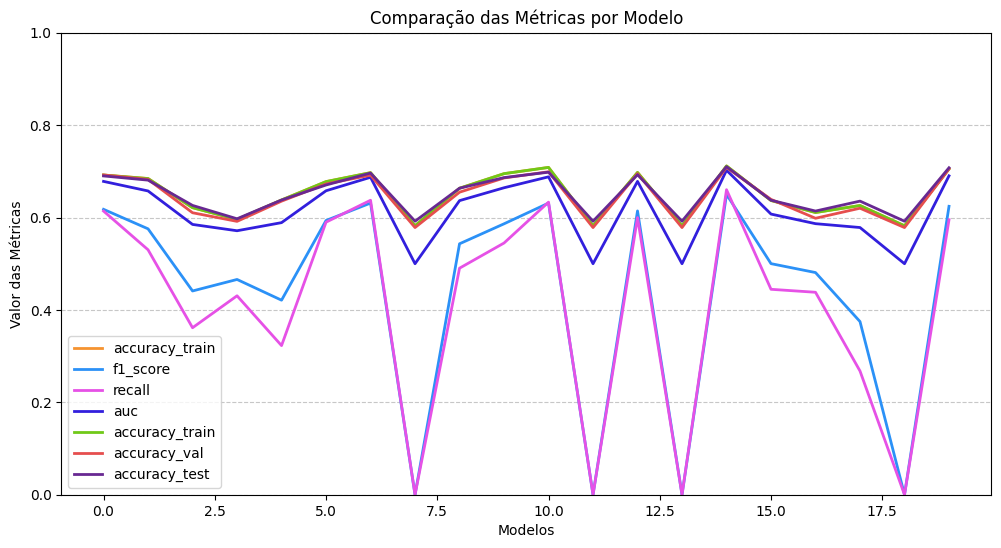

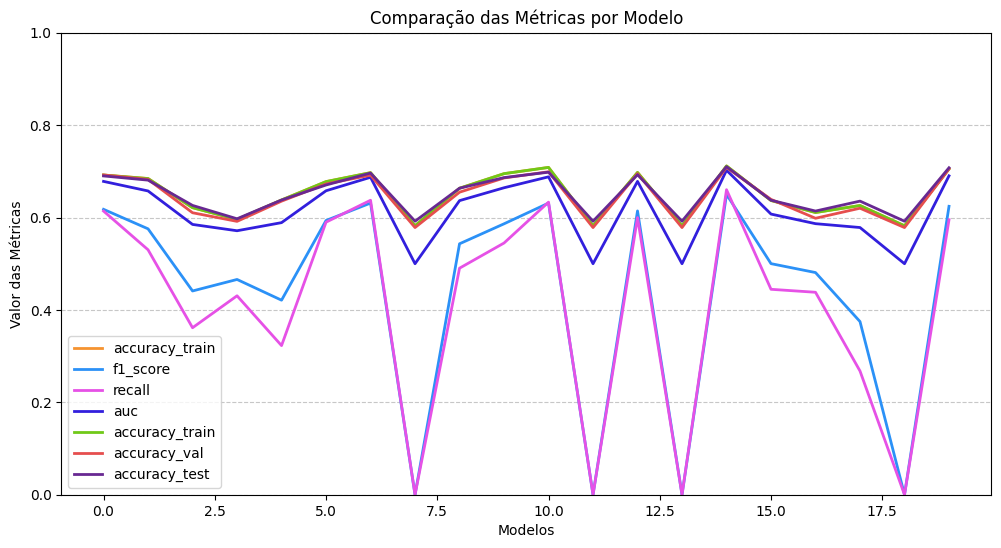

In [39]:
plots.show_metrics_comparison_line_plot(df, y_min= 0)

In [45]:
import pickle

model_path = '/home/guilhermemaciel/Área de Trabalho/SI5-ELEC2/models/lvq/14.pkl'
if os.path.exists(model_path):
    with open(model_path, "rb") as f:
        model = pickle.load(f)

In [33]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = map(np.array, [X_train, Y_train, X_val, Y_val, X_test, Y_test])


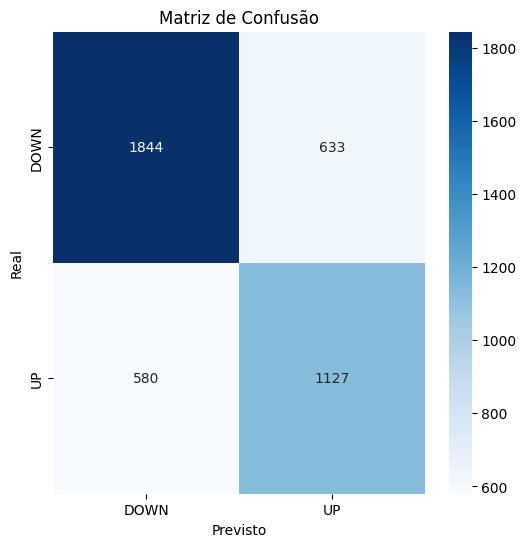

In [34]:
plots.show_confusion_matrix(model, X_test, Y_test)

In [37]:
model.get_params()

{'epochs': 100, 'lrate': 0.05, 'n_codebooks': 100}

### Cross-Validation

In [63]:
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, recall_score
import numpy as np
import time
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from tqdm.auto import tqdm

def cv_best_model(model,params,  X_t, Y_t):
    kfold = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)
    
    cv_metrics = []
    
    for fold, (train_idx, val_idx) in tqdm(enumerate(kfold.split(X_t, Y_t), 1), desc=f"Realizando CV dos parâmetros {params}"):
        X_train_fold, X_val_fold = X_t[train_idx], X_t[val_idx]
        Y_train_fold, Y_val_fold = Y_t[train_idx], Y_t[val_idx]
        
        # Treina o modelo
        model.set_params(**params)
        model.fit(X_train_fold, Y_train_fold)
        
        # Avalia o modelo no conjunto de validação do fold
        #fold_metrics = runner.evaluate_model_metrics(model, X_val_fold, Y_val_fold)
        #fold_metrics['fold'] = fold
        Y_pred_test = model.predict(X_val_fold)
        fold_metrics = runner.roc_auc_score(Y_val_fold, Y_pred_test)
        cv_metrics.append(fold_metrics)
    
    return sum(cv_metrics)/len(cv_metrics)

In [67]:
import ast

test = {}
for x, model_info in enumerate(df['params']):
    test[x] = cv_best_model(lvq_model, ast.literal_eval(model_info), X_test, Y_test)

Realizando CV dos parâmetros {'n_codebooks': 30, 'lrate': 0.1, 'epochs': 100}: 1it [00:25, 25.67s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 30, 'lrate': 0.1, 'epochs': 100}: 2it [00:50, 24.96s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 30, 'lrate': 0.1, 'epochs': 100}: 3it [01:16, 25.62s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 30, 'lrate': 0.1, 'epochs': 100}: 4it [01:42, 25.57s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 30, 'lrate': 0.1, 'epochs': 100}: 5it [02:07, 25.46s/it]


Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.05, 'epochs': 2}: 1it [00:00,  1.07it/s]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.05, 'epochs': 2}: 2it [00:01,  1.06it/s]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.05, 'epochs': 2}: 3it [00:02,  1.03it/s]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.05, 'epochs': 2}: 4it [00:03,  1.03it/s]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.05, 'epochs': 2}: 5it [00:04,  1.04it/s]


Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.01, 'epochs': 20}: 1it [00:01,  1.02s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.01, 'epochs': 20}: 2it [00:02,  1.03s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.01, 'epochs': 20}: 3it [00:03,  1.04s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.01, 'epochs': 20}: 4it [00:04,  1.05s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.01, 'epochs': 20}: 5it [00:05,  1.05s/it]


Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.05, 'epochs': 50}: 1it [00:02,  2.75s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.05, 'epochs': 50}: 2it [00:05,  2.75s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.05, 'epochs': 50}: 3it [00:07,  2.57s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.05, 'epochs': 50}: 4it [00:10,  2.50s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.05, 'epochs': 50}: 5it [00:12,  2.52s/it]


Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 10, 'lrate': 0.05, 'epochs': 2}: 1it [00:00,  5.34it/s]

Fim do treinameno
Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 10, 'lrate': 0.05, 'epochs': 2}: 3it [00:00,  5.35it/s]

Fim do treinameno
Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 10, 'lrate': 0.05, 'epochs': 2}: 5it [00:00,  5.11it/s]


Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 100, 'lrate': 0.01, 'epochs': 2}: 1it [00:01,  1.79s/it]

Fim do treinameno
Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 100, 'lrate': 0.01, 'epochs': 2}: 3it [00:05,  1.89s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 100, 'lrate': 0.01, 'epochs': 2}: 4it [00:07,  1.81s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 100, 'lrate': 0.01, 'epochs': 2}: 5it [00:09,  1.80s/it]


Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.1, 'epochs': 100}: 1it [00:40, 40.19s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.1, 'epochs': 100}: 2it [01:21, 40.94s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.1, 'epochs': 100}: 3it [02:01, 40.57s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.1, 'epochs': 100}: 4it [02:45, 41.87s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.1, 'epochs': 100}: 5it [03:26, 41.32s/it]


Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.01, 'epochs': 20}: 1it [00:01,  1.04s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.01, 'epochs': 20}: 2it [00:02,  1.06s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.01, 'epochs': 20}: 3it [00:03,  1.06s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.01, 'epochs': 20}: 4it [00:04,  1.06s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.01, 'epochs': 20}: 5it [00:05,  1.06s/it]


Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 30, 'lrate': 0.05, 'epochs': 20}: 1it [00:05,  5.23s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 30, 'lrate': 0.05, 'epochs': 20}: 2it [00:10,  5.17s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 30, 'lrate': 0.05, 'epochs': 20}: 3it [00:15,  5.26s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 30, 'lrate': 0.05, 'epochs': 20}: 4it [00:20,  5.23s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 30, 'lrate': 0.05, 'epochs': 20}: 5it [00:26,  5.24s/it]


Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.1, 'epochs': 2}: 1it [00:00,  1.04it/s]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.1, 'epochs': 2}: 2it [00:01,  1.13it/s]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.1, 'epochs': 2}: 3it [00:02,  1.16it/s]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.1, 'epochs': 2}: 4it [00:03,  1.18it/s]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.1, 'epochs': 2}: 5it [00:04,  1.16it/s]


Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 100, 'lrate': 0.1, 'epochs': 2}: 1it [00:01,  1.64s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 100, 'lrate': 0.1, 'epochs': 2}: 2it [00:03,  1.65s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 100, 'lrate': 0.1, 'epochs': 2}: 3it [00:04,  1.64s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 100, 'lrate': 0.1, 'epochs': 2}: 4it [00:06,  1.64s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 100, 'lrate': 0.1, 'epochs': 2}: 5it [00:08,  1.64s/it]


Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.5, 'epochs': 100}: 1it [00:41, 41.45s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.5, 'epochs': 100}: 2it [01:20, 39.96s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.5, 'epochs': 100}: 3it [01:56, 38.41s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.5, 'epochs': 100}: 4it [02:33, 37.60s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.5, 'epochs': 100}: 5it [03:10, 38.02s/it]


Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.01, 'epochs': 20}: 1it [00:07,  7.29s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.01, 'epochs': 20}: 2it [00:14,  7.39s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.01, 'epochs': 20}: 3it [00:22,  7.39s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.01, 'epochs': 20}: 4it [00:29,  7.39s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.01, 'epochs': 20}: 5it [00:36,  7.40s/it]


Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 30, 'lrate': 0.5, 'epochs': 2}: 1it [00:00,  1.99it/s]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 30, 'lrate': 0.5, 'epochs': 2}: 2it [00:00,  2.00it/s]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 30, 'lrate': 0.5, 'epochs': 2}: 3it [00:01,  1.99it/s]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 30, 'lrate': 0.5, 'epochs': 2}: 4it [00:02,  2.00it/s]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 30, 'lrate': 0.5, 'epochs': 2}: 5it [00:02,  2.00it/s]


Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 100, 'lrate': 0.05, 'epochs': 100}: 1it [01:12, 72.00s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 100, 'lrate': 0.05, 'epochs': 100}: 2it [02:23, 71.88s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 100, 'lrate': 0.05, 'epochs': 100}: 3it [03:36, 72.22s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 100, 'lrate': 0.05, 'epochs': 100}: 4it [04:48, 72.09s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 100, 'lrate': 0.05, 'epochs': 100}: 5it [06:01, 72.20s/it]


Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.05, 'epochs': 50}: 1it [00:02,  2.28s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.05, 'epochs': 50}: 2it [00:04,  2.27s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.05, 'epochs': 50}: 3it [00:06,  2.28s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.05, 'epochs': 50}: 4it [00:09,  2.28s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.05, 'epochs': 50}: 5it [00:11,  2.28s/it]


Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.01, 'epochs': 2}: 1it [00:00,  9.54it/s]

Fim do treinameno
Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.01, 'epochs': 2}: 2it [00:00,  9.71it/s]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.01, 'epochs': 2}: 4it [00:00,  9.66it/s]

Fim do treinameno
Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.01, 'epochs': 2}: 5it [00:00,  9.68it/s]
Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.01, 'epochs': 50}: 1it [00:02,  2.28s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.01, 'epochs': 50}: 2it [00:04,  2.27s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.01, 'epochs': 50}: 3it [00:06,  2.27s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.01, 'epochs': 50}: 4it [00:09,  2.29s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 5, 'lrate': 0.01, 'epochs': 50}: 5it [00:11,  2.28s/it]


Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.5, 'epochs': 100}: 1it [00:35, 35.97s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.5, 'epochs': 100}: 2it [01:11, 36.00s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.5, 'epochs': 100}: 3it [01:48, 36.34s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.5, 'epochs': 100}: 4it [02:24, 36.12s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 50, 'lrate': 0.5, 'epochs': 100}: 5it [03:00, 36.19s/it]


Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 100, 'lrate': 0.05, 'epochs': 2}: 1it [00:01,  1.69s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 100, 'lrate': 0.05, 'epochs': 2}: 2it [00:03,  1.65s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 100, 'lrate': 0.05, 'epochs': 2}: 3it [00:04,  1.67s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 100, 'lrate': 0.05, 'epochs': 2}: 4it [00:06,  1.65s/it]

Fim do treinameno


Realizando CV dos parâmetros {'n_codebooks': 100, 'lrate': 0.05, 'epochs': 2}: 5it [00:08,  1.66s/it]

Fim do treinameno


In [52]:
# Inicializando o markdown
markdown = "#### Resultados das Métricas:\n"

#Definindo as métricas a serem analisadas
metrics = ["accuracy_train", "accuracy_val", "accuracy_test", "f1_score", "auc", "recall"]


# Encontrar o modelo com o melhor AUC
best_model_row = max(df.iterrows(), key=lambda x: x[1]['auc'])  # Modelo com o maior AUC


# Iterando sobre as métricas para calcular os valores
for metric in metrics:
    # Obtendo os valores para cada métrica
    all_values = df[metric].values  # Acessando diretamente a coluna como um array NumPy
    
    # Calcular o melhor valor da métrica (máximo)
    best_value = max(all_values)
    
    # Calcular a média e desvio padrão da métrica
    avg_value = np.mean(all_values)
    std_value = np.std(all_values)
    
    # Encontrar o valor do modelo selecionado (o modelo com o melhor AUC)
    model_value = best_model_row[1][metric]  # Acessando a linha do modelo com melhor AUC
    
    # Adicionando os resultados ao markdown
    markdown += f"- **{metric.replace('_', ' ').capitalize()}**:\n"
    markdown += f"  - **Melhor valor geral**: {best_value:.4f}\n"
    markdown += f"  - **Média**: {avg_value:.4f}\n"
    markdown += f"  - **Desvio Padrão**: {std_value:.4f}\n"
    markdown += f"  - **Valor no Modelo Selecionado**: {model_value:.4f}\n\n"

# Exibindo o resultado final do markdown
print(markdown)


#### Resultados das Métricas:
- **Accuracy train**:
  - **Melhor valor geral**: 0.7116
  - **Média**: 0.6495
  - **Desvio Padrão**: 0.0476
  - **Valor no Modelo Selecionado**: 0.7116

- **Accuracy val**:
  - **Melhor valor geral**: 0.7083
  - **Média**: 0.6448
  - **Desvio Padrão**: 0.0480
  - **Valor no Modelo Selecionado**: 0.7083

- **Accuracy test**:
  - **Melhor valor geral**: 0.7101
  - **Média**: 0.6506
  - **Desvio Padrão**: 0.0426
  - **Valor no Modelo Selecionado**: 0.7101

- **F1 score**:
  - **Melhor valor geral**: 0.6501
  - **Média**: 0.4376
  - **Desvio Padrão**: 0.2315
  - **Valor no Modelo Selecionado**: 0.6501

- **Auc**:
  - **Melhor valor geral**: 0.7023
  - **Média**: 0.6129
  - **Desvio Padrão**: 0.0696
  - **Valor no Modelo Selecionado**: 0.7023

- **Recall**:
  - **Melhor valor geral**: 0.6602
  - **Média**: 0.4080
  - **Desvio Padrão**: 0.2294
  - **Valor no Modelo Selecionado**: 0.6602




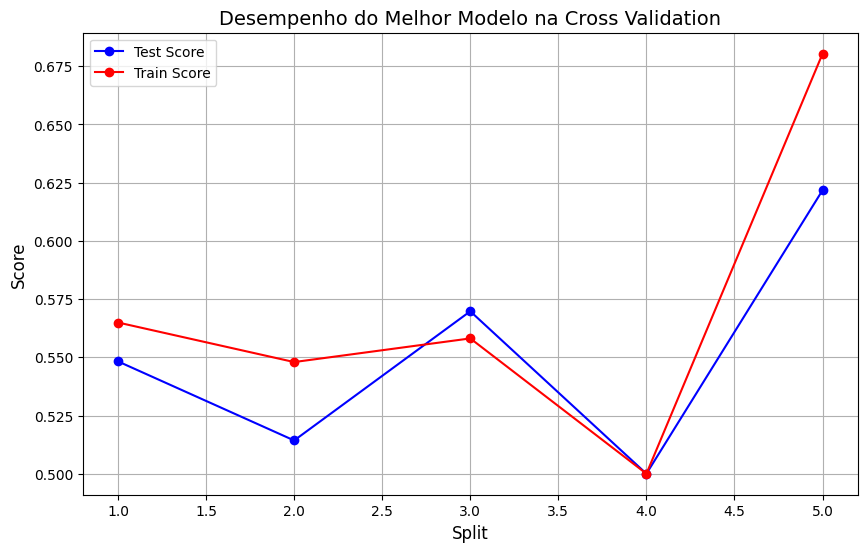

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Criando o gráfico
plt.figure(figsize=(10, 6))

# Plotando o desempenho de teste
plt.plot(range(1, 6), list(test.values())[15:20], label='Test Score', marker='o', linestyle='-', color='blue')

# Plotando o desempenho de treino
plt.plot(range(1, 6), list(train.values())[15:20], label='Train Score', marker='o', linestyle='-', color='red')

# Adicionando rótulos e título
plt.xlabel('Split', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title("Desempenho do Melhor Modelo na Cross Validation", fontsize=14)

# Adicionando a legenda
plt.legend()

# Exibindo a grade
plt.grid(True)

# Exibindo o gráfico
plt.show()